In [57]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 확인
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset 만들기
import keras
from keras.utils import to_categorical

# Detect Face
import cv2
from scipy.ndimage import zoom

# Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [41]:
df = pd.read_csv('./data/fer2013.csv')

# 이미지 픽셀 list로 만들기
df['pixels'] = df['pixels'].apply(lambda pixel: np.fromstring(pixel, sep=' '))
df.head()

,emotion,pixels,Usage
0,0,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63....",Training
1,0,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111...",Training
2,2,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161...",Training
3,4,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20....",Training
4,6,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Training


In [42]:
# train test 나누기
train_df = df[df['Usage']=='Training']
test_df = df[df['Usage']=='PublicTest']
print(train_df.shape)
print(test_df.shape)

(28709, 3)
(3589, 3)


In [43]:
shape_x = 48
shape_y = 48

# X_train, y_train, X_test, y_test split
X_train = train_df.iloc[:, 1].values # pixles
y_train = train_df.iloc[:, 0].values # emotion

X_test = test_df.iloc[:, 1].values # pixles
y_test = test_df.iloc[:, 0].values # emotion

# 전체데이터
X = df.iloc[:, 1].values # pixles
y = df.iloc[:, 0].values # emotion

# array([array([....])]) 구조를 바꾸기 위한 np.vstack
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
X = np.vstack(X)

In [44]:
# 4차원 데이터셋 만들기 (데이터개수, x축, y축, rgb)
X_train_ds = np.reshape(X_train, (X_train.shape[0], shape_x, shape_y, 1))
y_train_ds = np.reshape(y_train, (y_train.shape[0], 1))

X_test_ds = np.reshape(X_test, (X_test.shape[0], shape_x, shape_y, 1))
y_test_ds = np.reshape(y_test, (y_test.shape[0], 1))

print(X_train_ds.shape, y_train_ds.shape)
print(X_test_ds.shape, y_test_ds.shape)

(28709, 48, 48, 1) (28709, 1)
(3589, 48, 48, 1) (3589, 1)


In [45]:
# 데이터타입 float로 변경
train_data = X_train_ds.astype('float32')
test_data = X_test_ds.astype('float32')

# 스케일링
train_data /= 225
test_data /= 225

# y데이터 원핫인코딩
train_labels_onehot = to_categorical(y_train_ds)
test_labels_onehot = to_categorical(y_test_ds)

# input_shape 설정
n_rows, n_cols, n_dims = X_train_ds.shape[1:]
input_shape = (n_rows, n_cols, n_dims)
print(input_shape)

(48, 48, 1)


Text(0.5, 1.0, 'Ground Truth : happy')

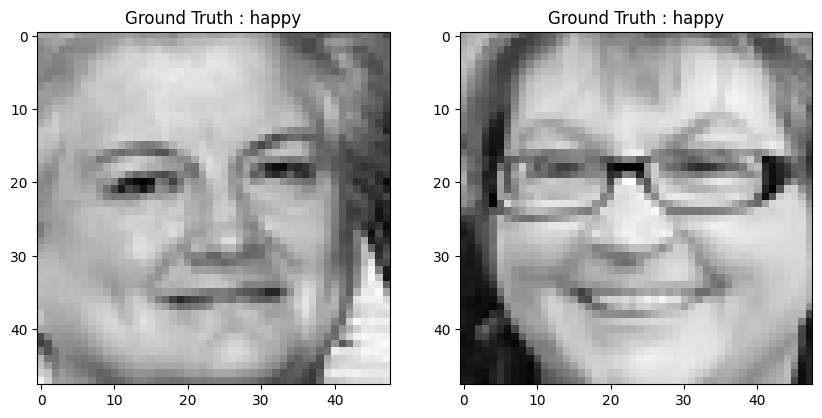

In [46]:
# 라벨 숫자를 문자로 변경
def get_label(argument):
    labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
    return(labels.get(argument, 'Invalid emotion'))
    
# 데이터 시각화
plt.figure(figsize=[10,5])

# Train data 중 100번째 이미지
n=100

plt.subplot(121)
plt.imshow(np.squeeze(X_train_ds[n,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[n]))))

# Test data 중 100번째 이미지
plt.subplot(122)
plt.imshow(np.squeeze(X_test_ds[n,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[n]))))

In [47]:
# 전체 이미지에서 얼굴을 찾아내는 함수
def detect_face(frame):
    
    # cascade pre-trained 모델 불러오기
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # RGB를 gray scale로 바꾸기
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # cascade 멀티스케일 분류
    detected_faces = face_cascade.detectMultiScale(gray,
                                                   scaleFactor = 1.1,
                                                   minNeighbors = 6,
                                                   minSize = (shape_x, shape_y),
                                                   flags = cv2.CASCADE_SCALE_IMAGE
                                                  )
    
    coord = []
    for x, y, w, h in detected_faces:
        if w > 100:
            sub_img = frame[y:y+h, x:x+w]
            coord.append([x, y, w, h])
            
    return gray, detected_faces, coord

In [48]:
# 전체 이미지에서 찾아낸 얼굴을 추출하는 함수
def extract_face_features(gray, detected_faces, coord, offset_coefficients=(0.075, 0.05)):
    new_face = []
    for det in detected_faces:
        
        # 얼굴로 감지된 영역
        x, y, w, h = det
        
        # 이미지 경계값 받기
        horizontal_offset = int(np.floor(offset_coefficients[0] * w))
        vertical_offset = int(np.floor(offset_coefficients[1] * h))

        
        # gray scacle 에서 해당 위치 가져오기
        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
        
        # 얼굴 이미지만 확대
        new_extracted_face = zoom(extracted_face, (shape_x/extracted_face.shape[0], shape_y/extracted_face.shape[1]))
        new_extracted_face = new_extracted_face.astype(np.float32)
        new_extracted_face /= float(new_extracted_face.max()) # sacled
        new_face.append(new_extracted_face)
        
    return new_face

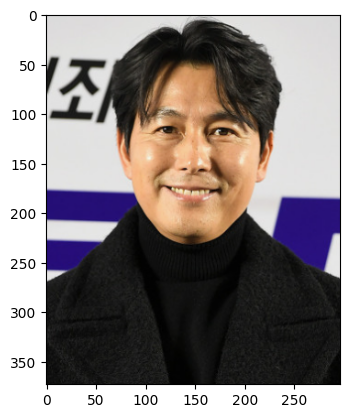

In [49]:
suzy = cv2.imread('./data/e_neutral.png')
plt.imshow(cv2.cvtColor(suzy, cv2.COLOR_BGR2RGB))

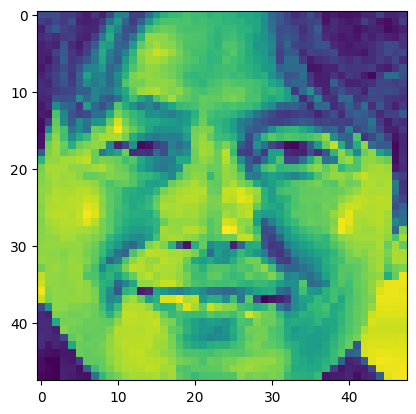

In [50]:
# 얼굴 찾기
gray, detected_faces, coord = detect_face(suzy)

# 찾은 얼굴 추출하기
face_zoom = extract_face_features(gray, detected_faces, coord)

# 시각화
plt.imshow(face_zoom[0])

In [51]:
def simple_model():
    model = Sequential()
    
    # Input layer
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    
    # Add layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    # Flatten
    model.add(Flatten())
    
    # Fully connected layer
    model.add(Dense(512, activation='relu'))
    
    # Output layer : n_classes=7
    model.add(Dense(7, activation='softmax'))
    
    return model

In [52]:
model = simple_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 46, 46, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 23, 23, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 667,239 (2.55 MB)

 Trainable params: 667,239 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# 이미지 데이터 증강
datagen = ImageDataGenerator(zoom_range=0.2,          # 랜덤하게 이미지 줌 하는 비율
                             rotation_range=10,       # 램덤하게 이미지 회전하는 비율 (0도~180도)
                             width_shift_range=0.1,   # 랜덤하게 이미지 가로로 이동하는 비율
                             height_shift_range=0.1,  # 랜덤하게 이미지 세로로 이동하는 비율
                             horizontal_flip=True,    # 랜덤하게 이미지 수평 뒤집기
                             vertical_flip=False)     # 랜덤하게 이미지 수직 뒤집기
                             
# 모델 학습을 위한 파라미터 설정
batch_size = 256
n_epochs = 100
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(datagen.flow(train_data, train_labels_onehot, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(train_data.shape[0]/float(batch_size))),
                              epochs=n_epochs,
                              validation_data=(test_data, test_labels_onehot)
                             )

Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 342ms/step - accuracy: 0.2435 - loss: 1.8319 - val_accuracy: 0.2761 - val_loss: 1.7694
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2761 - val_loss: 1.7694
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 379ms/step - accuracy: 0.2785 - loss: 1.7570 - val_accuracy: 0.3561 - val_loss: 1.6348
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3561 - val_loss: 1.6348
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 68s 601ms/step - accuracy: 0.3251 - loss: 1.6834 - val_accuracy: 0.4007 - val_loss: 1.5256
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4007 - val_loss: 1.5256
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 75s 662ms/step - accuracy: 0.3779 - loss: 1.5862 - val_accuracy: 0.4586 - val_loss: 1.4178
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - ac

Text(0.5, 1.0, 'Accuracy Curves')

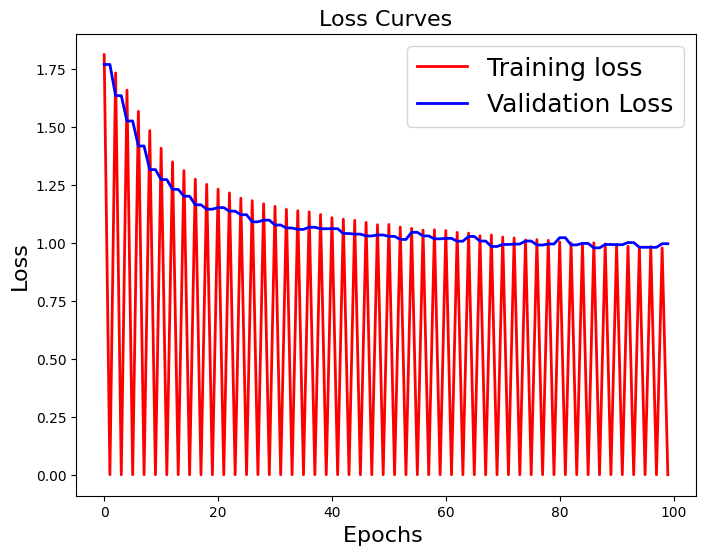

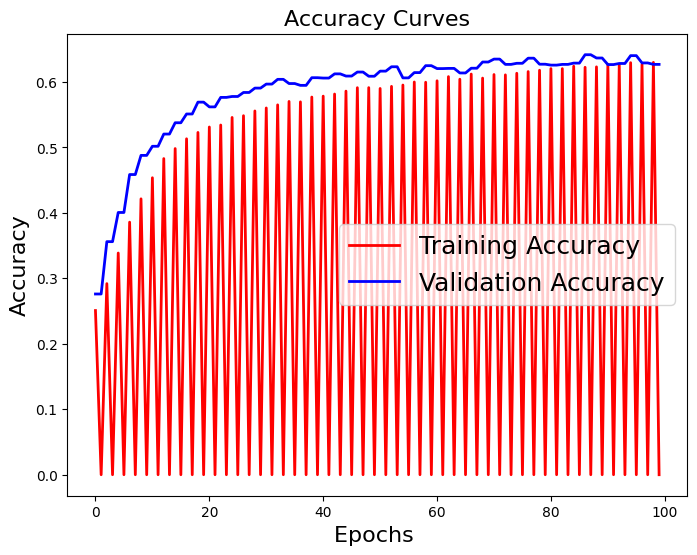

In [55]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [56]:
from tensorflow.keras.models import save_model

# 모델 저장
save_model(model, 'face_emotion.h5')
